In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cobra.flux_analysis import flux_variability_analysis as fva
from gsmmutils.model.COBRAmodel import *
import seaborn as sns
sns.set(rc={'figure.figsize':(35,8.27)})

In [3]:
def read_model(data_directory):
    model_to_load = MyModel(join(data_directory, "models/model_with_trials.xml"), "e_Biomass__cytop")
    model_to_load.add_medium(join(data_directory, "media.xlsx"), "base_medium")
    return model_to_load

def convert_light_uptake(umol_m2_s):
    return umol_m2_s*5.7

def convert_light_uptake_rev(mmol_gDW_d):
    return mmol_gDW_d/5.7

model = read_model("../data")

Loading
Reactions: 4653
Metabolites: 3733
Genes: 1692
Model loaded


In [4]:
model.exchanges.EX_C00011__dra.bounds = (-8.21 / 24, 1000)
model.reactions.ATPm__cytop.bounds = (2.85 / 24, 2.85 / 24)
model.exchanges.EX_C00205__dra.bounds = (-1000, 1000)
model.reactions.e_Pigment__chlo.bounds = (0, 1000)

In [5]:
with model as model_copy:
    from cobra.flux_analysis import pfba
    fluxes = (15, 6)
    constraint = model_copy.problem.Constraint(
            model_copy.reactions.R09542_hn437__chlo.flux_expression + model_copy.reactions.R09542_hn680__chlo.flux_expression,
            lb=fluxes[0],
            ub=fluxes[0])
    model_copy.add_cons_vars(constraint)
    constraint = model_copy.problem.Constraint(
        model_copy.reactions.R09503_hn438__lum.flux_expression + model_copy.reactions.R09503_hn673__lum.flux_expression,
        lb=fluxes[1],
        ub=fluxes[1])
    model_copy.add_cons_vars(constraint)
    sol = model_copy.optimize()
    print(sol['R09542_hn437__chlo'])
    print(sol['R09542_hn680__chlo'])
    # print(fva(model_copy, ['R09503_hn438__lum', 'R09503_hn673__lum'], fraction_of_optimum=0.01))
    print(sol.status)
    # print(pfba(model_copy))

1.4696200604111085
13.530379939588892
optimal


In [11]:
model.reactions.R09503_hn438__lum.bounds = (5,5)
model.reactions.R09503_hn673__lum.bounds = (5,5)
model.reactions.R09542_hn680__chlo.bounds = (12,12)

In [12]:
model.summary()

Running pFBA


Metabolite,Reaction,Flux,C-Number,C-Flux
C00001__extr,EX_C00001__dra,1.737,0,0.00%
C00009__extr,EX_C00009__dra,16.42,0,0.00%
C00011__extr,EX_C00011__dra,0.3421,1,99.75%
C00059__extr,EX_C00059__dra,0.0008718,0,0.00%
C00120__extr,EX_C00120__dra,3.163E-05,10,0.09%
C00205__extr,EX_C00205__dra,435.6,0,0.00%
C00244__extr,EX_C00244__dra,0.02155,0,0.00%
C00305__extr,EX_C00305__dra,4.14E-06,0,0.00%
C00378__extr,EX_C00378__dra,1.818E-05,12,0.06%
C01330__extr,EX_C01330__dra,0.09602,0,0.00%


In [25]:
fva(model, ['R09503_hn438__lum', 'R09503_hn673__lum', 'R09542_hn437__chlo', 'R09542_hn680__chlo'], fraction_of_optimum=0.01)

,minimum,maximum
R09503_hn438__lum,5.000000,5.00000
R09503_hn673__lum,5.000000,5.00000
R09542_hn437__chlo,5.782573,7.11767
R09542_hn680__chlo,12.000000,12.00000


In [7]:
light_sources = [reaction.id for reaction in model.reactions if  "PRISM" in reaction.id]

In [13]:
results = {}
for light_reaction in light_sources:
    with model:
        model.reactions.e_Biomass__cytop.bounds = (0.2, 0.2)
        model.objective = "EX_C00205__dra"
        model.reactions.get_by_id(light_reaction).bounds = (0, 1000)
        for other_reaction in light_sources:
            if other_reaction != light_reaction:
                model.reactions.get_by_id(other_reaction).bounds = [0, 0]
        sol = model.optimize()
        results[light_reaction] = {'biomass': sol["e_Biomass__cytop"], "light_reaction": sol[light_reaction]}

C:\Users\Bisbii\mambaforge-pypy3\envs\GSMMutils\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Bisbii\mambaforge-pypy3\envs\GSMMutils\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Bisbii\mambaforge-pypy3\envs\GSMMutils\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Bisbii\mambaforge-pypy3\envs\GSMMutils\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Bisbii\mambaforge-pypy3\envs\GSMMutils\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Bisbii\mambaforge-pypy3\envs\GSMMutils\lib\sit

<AxesSubplot:>

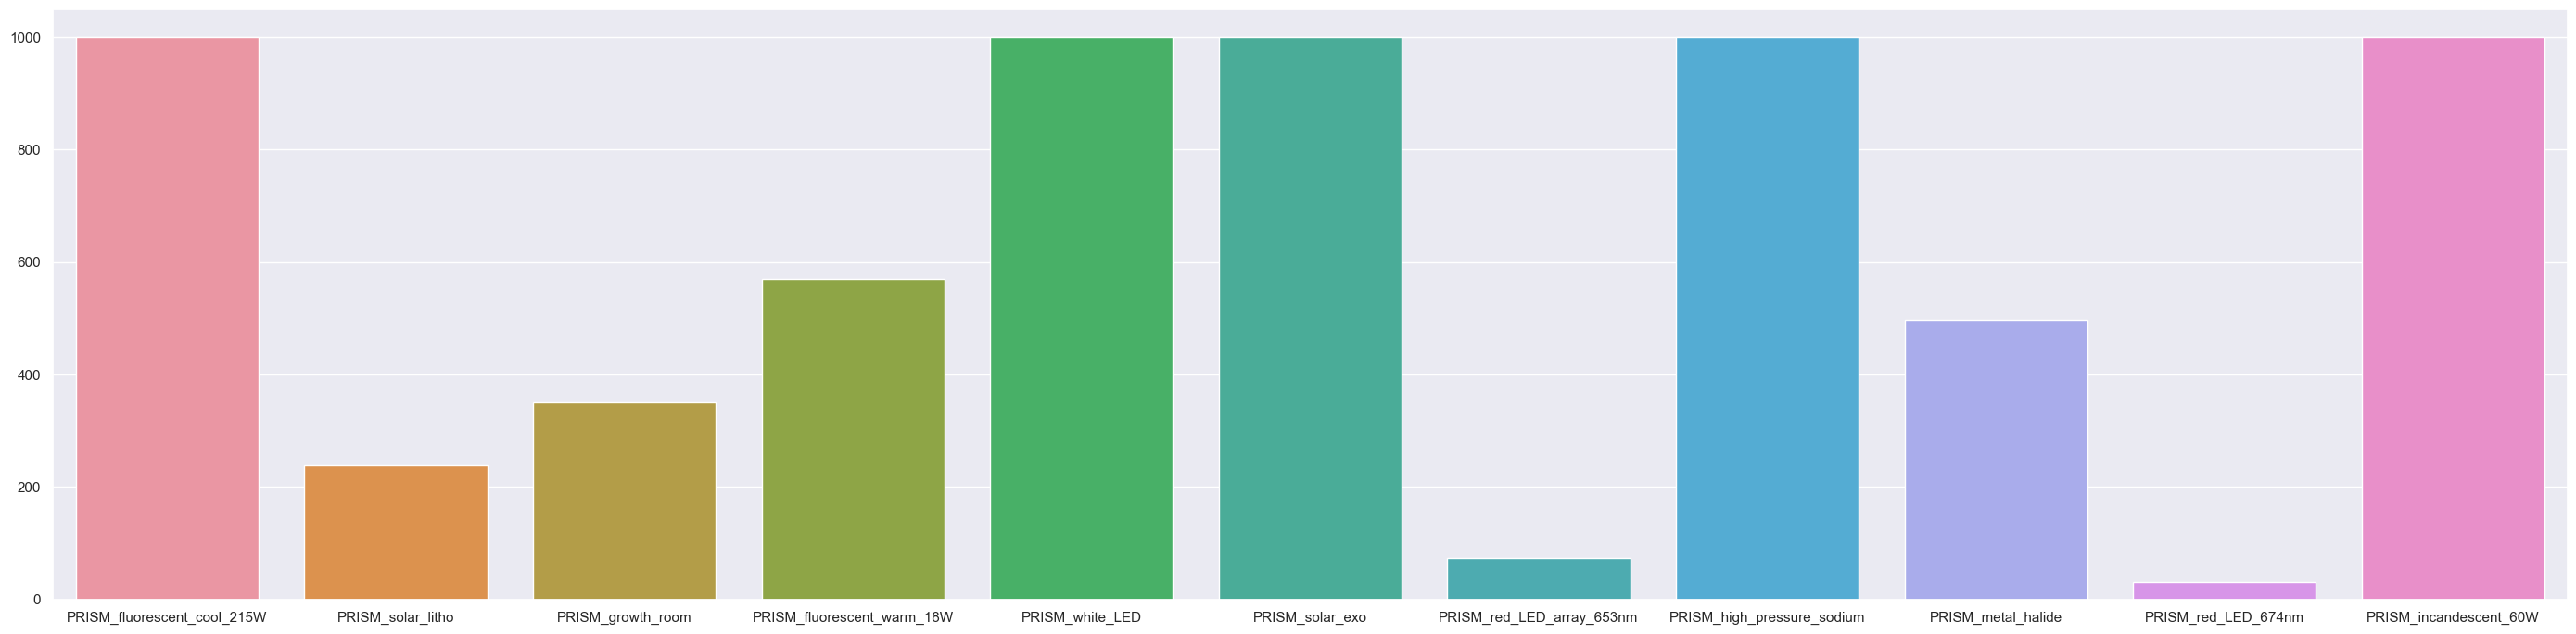

In [14]:
sns.barplot(x=list(key.split("__")[0] for key in results.keys()), y=list(val['light_reaction'] for val in results.values()))

In [69]:
from cobra.flux_analysis import pfba


def run_simulation(model_copy, i):
    res, res_o2, quantum_yield, res_flv, fva_sols, pfba_sol, quantum_yield_pfba  = 0, 0, 0, (0,0), [], 0, 0
    model_copy.exchanges.EX_C00205__dra.bounds = (-i,-i)
    sol = model.optimize()
    if sol != 0 and sol.status == 'optimal':
        try:
            pfba_sol = pfba(model_copy)
            quantum_yield_pfba = pfba_sol['R00024__chlo']/(pfba_sol["R09503_hn438__lum"]+pfba_sol["R09503_hn673__lum"])
            pfba_sol = pfba_sol['e_Biomass__cytop']
        except:
            pass
        res = sol['e_Biomass__cytop']
        res_o2 = sol["R09503_hn438__lum"]+sol["R09503_hn673__lum"]
        res_flv = sol['FLV__chlo']
        # fva_sol = fva(model, ["R09503_hn438__lum", "R09503_hn673__lum", 'FLV__chlo'], processes=8)
        # fva_sols.append(fva_sol)
        quantum_yield = sol['R00024__chlo']/(sol["R09503_hn438__lum"]+sol["R09503_hn673__lum"])
    return res, res_o2, quantum_yield, res_flv, fva_sols, pfba_sol, quantum_yield_pfba, i

In [71]:
from joblib import delayed, Parallel
with model:
    model.exchanges.EX_C00011__dra.bounds = (-8.21, 10000)
    for reaction in model.reactions:
        if reaction.lower_bound < -500: reaction.lower_bound = -10000
        if reaction.upper_bound > 500: reaction.upper_bound = 10000
    light_range = np.arange(0, 1000, 100)
    result= Parallel(n_jobs=6)(delayed(run_simulation)(model, e) for e in light_range)
    res = [e[0] for e in result]
    res_o2 = [e[1] for e in result]
    quantum_yield = [e[2] for e in result]
    res_flv = [e[3] for e in result]
    fva_sols = [e[4] for e in result]
    pfba_sol = [e[5] for e in result]
    quantum_yield_pfba = [e[6] for e in result]

In [59]:
quantum_yield_pfba

[0,
 {100: 0.6243038653467162},
 0,
 {300: 0.6360820800643305},
 {400: 0.6449126784448648},
 {500: 0.650209692697606},
 {600: 0.6199175610281149},
 {700: 0.640048276502949},
 {800: 0.6400482765029495},
 {900: 0.6400482765029483}]

<AxesSubplot:>

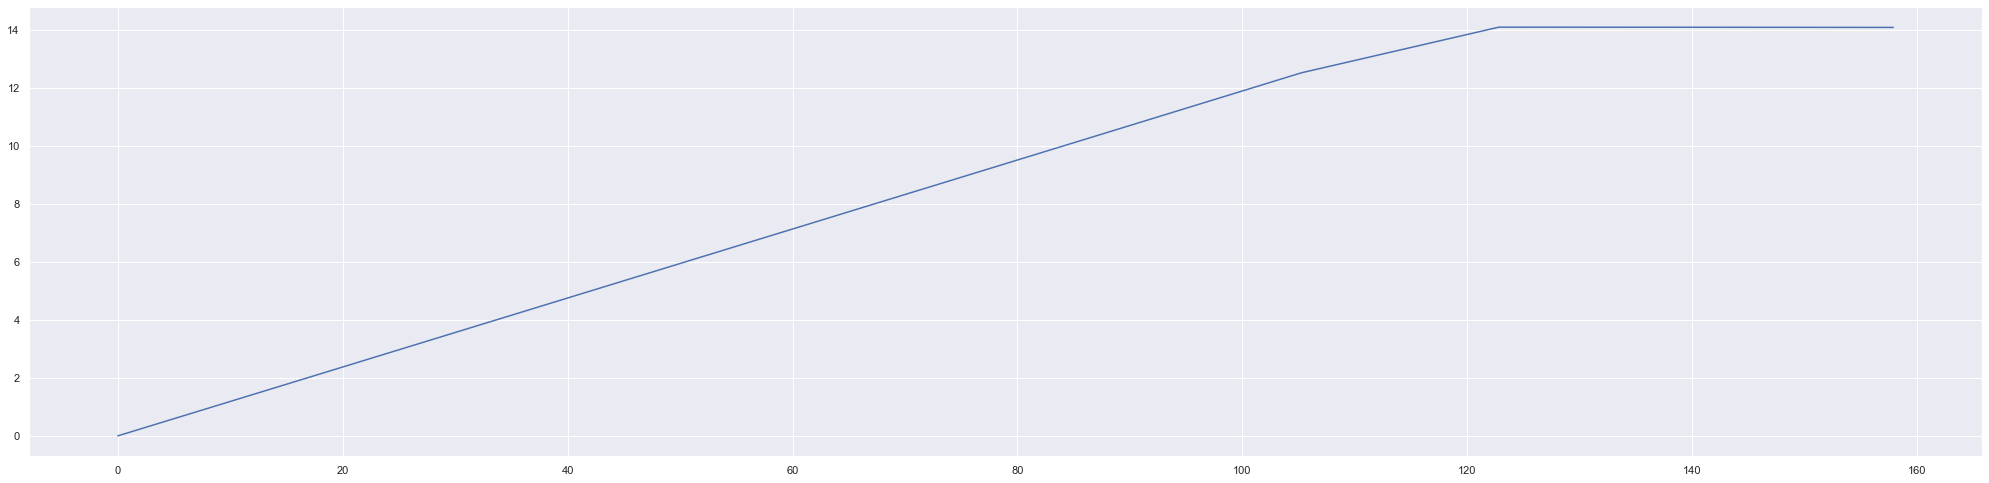

In [38]:
sns.lineplot([convert_light_uptake_rev(e) for e in light_range], res_o2)

In [49]:
res

[0,
 0.029670655899268414,
 0.06519238174247999,
 0.10061474620342976,
 0.13603711308618208,
 0.1714594824570219,
 0.20339042505326013,
 0.20339042505326013,
 0.20339042505325966,
 0.20339042505325997]

In [41]:
[convert_light_uptake_rev(e) for e in light_range]

[0.0,
 17.543859649122805,
 35.08771929824561,
 52.63157894736842,
 70.17543859649122,
 87.71929824561403,
 105.26315789473684,
 122.80701754385964,
 140.35087719298244,
 157.89473684210526]

In [68]:
with model:
    model.exchanges.EX_C00011__dra.bounds = (-8.21, 10000)
    for reaction in model.reactions:
        if reaction.lower_bound < -500: reaction.lower_bound = -10000
        if reaction.upper_bound > 500: reaction.upper_bound = 10000
    model.exchanges.EX_C00205__dra.bounds = (-200, -200)
    pfba_sol = pfba(model)
    quantum_yield_pfba = pfba_sol['R00024__chlo']/(pfba_sol["R09503_hn438__lum"]+pfba_sol["R09503_hn673__lum"])
    print(model.summary(pfba_sol))
    print(quantum_yield_pfba)

Runnning pFBA
Objective
1.0 e_Biomass__cytop = 0.06519237932067398

Uptake
------
   Metabolite        Reaction      Flux  C-Number  C-Flux
 C00001__extr  EX_C00001__dra     2.168         0   0.00%
 C00009__extr  EX_C00009__dra   0.01028         0   0.00%
 C00011__extr  EX_C00011__dra     2.632         1  99.75%
 C00059__extr  EX_C00059__dra  0.006834         0   0.00%
 C00080__extr  EX_C00080__dra   0.01733         0   0.00%
 C00120__extr  EX_C00120__dra 0.0002468        10   0.09%
 C00205__extr  EX_C00205__dra       200         0   0.00%
 C00244__extr  EX_C00244__dra    0.1688         0   0.00%
 C00305__extr  EX_C00305__dra 1.779E-06         0   0.00%
 C00378__extr  EX_C00378__dra 0.0001418        12   0.06%
 C02823__extr  EX_C02823__dra 3.816E-05        63   0.09%
 C14818__extr  EX_C14818__dra 0.0007843         0   0.00%

Secretion
---------
       Metabolite             Reaction       Flux  C-Number   C-Flux
 photon298__cytop  DM_photon298__cytop   -0.04444         0    0.00%
  pho

TypeError: Invalid object type at position 1

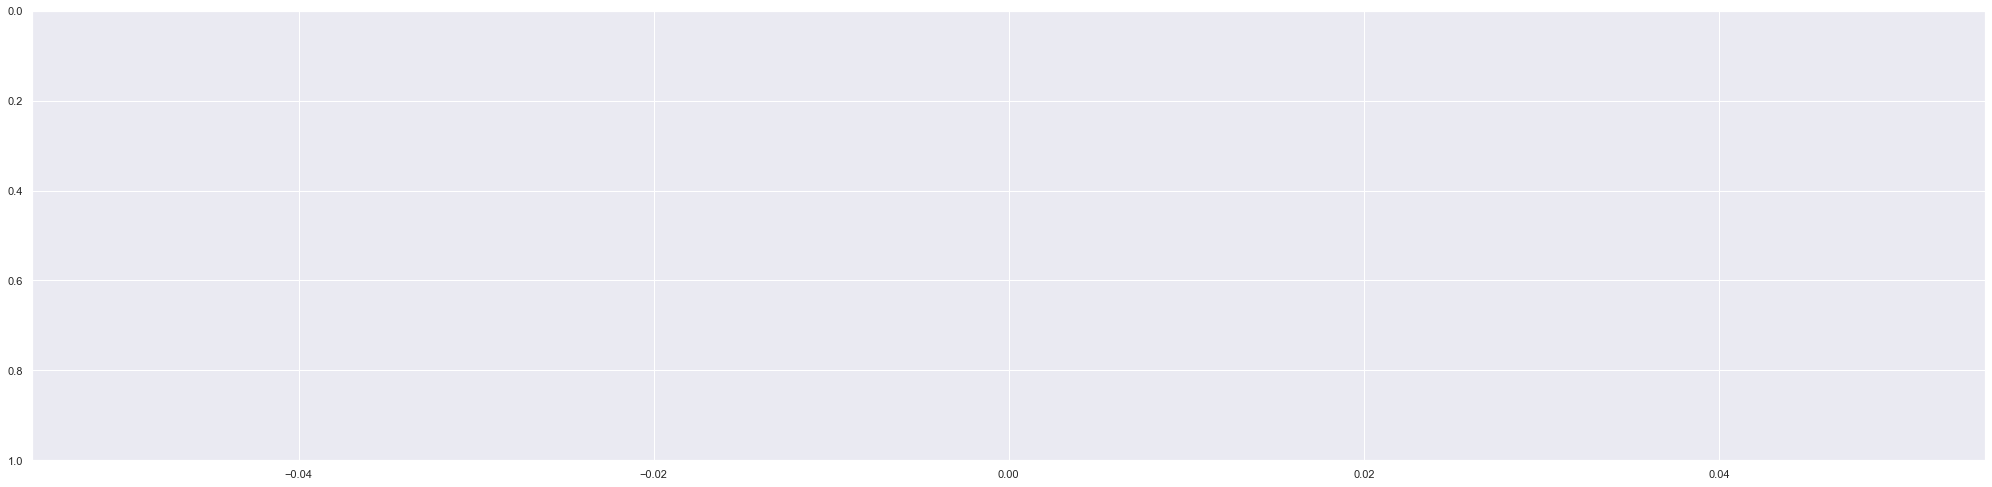

In [29]:
sns.lineplot([convert_light_uptake_rev(e) for e in light_range], pfba_sol)

<AxesSubplot:>

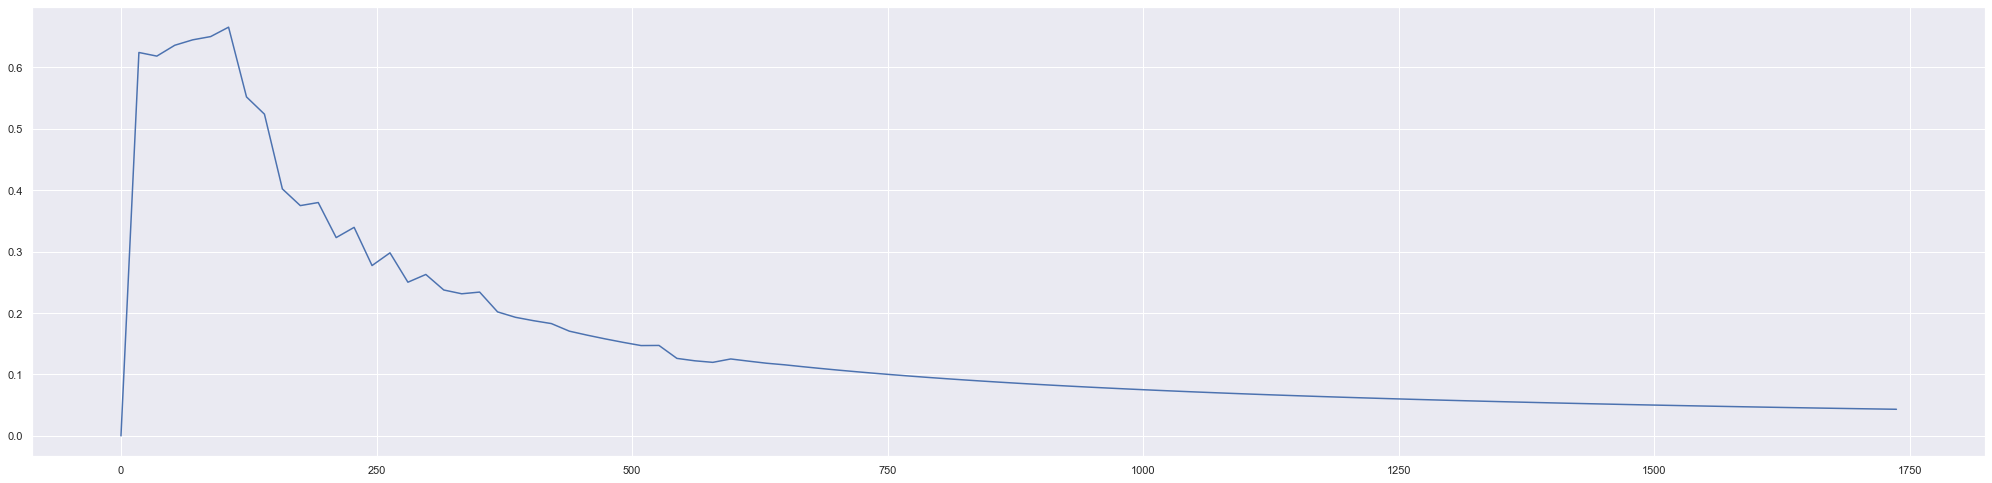

In [18]:
sns.lineplot([convert_light_uptake_rev(e) for e in light_range], quantum_yield)

In [ ]:
as_dict = []
for i in fva_sols:
    if type(i) == pd.DataFrame:
        as_dict.append([i.loc["R09503_hn438__lum"].minimum, i.loc["R09503_hn438__lum"].maximum])
    else:
        as_dict.append([0,0])

In [ ]:
sns.barplot(light_range, [e[1] for e in as_dict], color = "g")

In [ ]:
fig = plt.Figure()
sns.lineplot(light_range, res, color="g")
ax2 = plt.twinx()
sns.lineplot(light_range, res_o2)
plt.show()

In [ ]:
with model:
    sol = model.optimize()
    print(sol.objective_value)
    print(sol['FLV__chlo'])
    # print(fva(model, ['FLV__chlo']))
    print(model.metabolites.C00006__chlo.summary(fva=1.0))